In [1]:
import pandas as pd 
import numpy as np
import datetime as dt
import glob
import seaborn as sns

In [2]:
##CARGANDO TRANSFERENCIAS

path = "C:\\Users\\jloayzap\\Documents\\JLP\\ANALISIS_OPERACIONES\\TRANSFERENCIAS"

filenames = glob.glob(path + "\*.xlsx")
#print('File names:', filenames)
df_trans = pd.DataFrame()

for f in filenames:
    data = pd.read_excel(f, 'Hoja1', converters={'Número Unico de Operación':str})
    df_trans = df_trans.append(data)
    
df_trans['CCI_Destino_2'] = np.where(df_trans['CCI Destino'].str.len() == 20, df_trans['CCI Destino'], '0' + df_trans['CCI Destino'].astype(str))
df_trans["ANIO"] = df_trans['Fecha Presentación'].str[:4] 
df_trans["MES"] = df_trans['Fecha Presentación'].str[5:7]
df_trans['ANIOMES'] = df_trans['ANIO'].astype(str) + df_trans['MES'].astype(str)
df_trans["Importe Transferencia"] = df_trans.rename(columns={'Importe Transferencia':'IMPORTE'}, inplace = True)
df_trans['IMPORTE_FINAL'] = df_trans['IMPORTE'].astype(float)

In [3]:
##PARTICIONANDO BASE 
#ENTRADAS
df_trans_ent = df_trans[df_trans['Transferencia'] == 'E - ENTR']
df_trans_ent = df_trans_ent[df_trans_ent.Estado.isin(['4 - Conforme', '5 - Conforme Abonado'])]

#SALIDAS
df_trans_sal = df_trans[df_trans['Transferencia'] == 'S - SALID']
df_trans_sal = df_trans_sal[df_trans_sal.Estado.isin(['4 - Conforme', '5 - Conforme Abonado'])]

In [4]:
##CARGANDO SALDOS
df_saldos = pd.read_csv("C:\\Users\\jloayzap\\Documents\\JLP\\SALDOS_MOVIMIENTO\\SALDOS\\Saldos.csv", sep = ";", converters={'NROCUENTA':str, 'NUMERODOCUMENTO':str, 'CCICODE':str})

C:\Users\jloayzap\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (23,29,42,43) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
#Obteniendo DNI Clientes
##OBTENIENDO DNI CIENTE DESDE BASE DE SALDOS
df_trans_ent = df_trans_ent.merge(df_saldos[['CCICODE', 'TIPODOCUMENTO', 'NUMERODOCUMENTO']], left_on ='CCI_Destino_2', right_on='CCICODE', how='left')
df_trans_ent.head()

,Transferencia,Fecha Presentación,Fecha Liquidación,Sesión,Moneda,IMPORTE,Comisión Interbancaria,Comisión Cliente,Comisión Rechazo Cliente,Itf Transferencia,...,Secuencia Transf. Multiples,CCI_Destino_2,ANIO,MES,ANIOMES,Importe Transferencia,IMPORTE_FINAL,CCICODE,TIPODOCUMENTO,NUMERODOCUMENTO
0,E - ENTR,2021-08-31,2021-08-31,1 - Turno Mañana,1 - Soles,187.76,0.0,0.0,0,0.0,...,NaN,05410780010085561386,2021,08,202108,None,187.76,05410780010085561386,1.0,08269277
1,E - ENTR,2021-08-31,2021-08-31,1 - Turno Mañana,1 - Soles,95.00,0.0,0.0,0,0.0,...,NaN,05488882888002871732,2021,08,202108,None,95.00,05488882888002871732,1.0,41300587
2,E - ENTR,2021-08-31,2021-08-31,1 - Turno Mañana,1 - Soles,350.00,0.0,0.0,0,0.0,...,NaN,05430180010043326077,2021,08,202108,None,350.00,05430180010043326077,1.0,18078194
3,E - ENTR,2021-08-31,2021-08-31,1 - Turno Mañana,1 - Soles,34.00,0.0,0.0,0,0.0,...,NaN,05431480010032842201,2021,08,202108,None,34.00,05431480010032842201,1.0,40744416
4,E - ENTR,2021-08-31,2021-08-31,1 - Turno Mañana,1 - Soles,210.00,0.0,0.0,0,0.0,...,NaN,05460280010115910780,2021,08,202108,None,210.00,05460280010115910780,1.0,45008527


In [7]:
grupo = pd.DataFrame()
grupo = df_trans_ent.groupby(['NUMERODOCUMENTO', 'ANIOMES']).NUMERODOCUMENTO.size()
df_trans_ent_grupo = pd.DataFrame(grupo.reset_index(name='CUENTA_OP'))
df_trans_ent_grupo.sort_values(['NUMERODOCUMENTO', 'ANIOMES'], ascending=False)
df_trans_ent_grupo['LLAVE'] = df_trans_ent_grupo['NUMERODOCUMENTO'].astype(str) + df_trans_ent_grupo['ANIOMES'].astype(str)

grupo = pd.DataFrame()
grupo = df_trans_ent.groupby(['NUMERODOCUMENTO', 'ANIOMES']).IMPORTE.sum()
df_trans_ent_sum = pd.DataFrame(grupo.reset_index(name='SUMA_OP'))
df_trans_ent_sum.sort_values(['NUMERODOCUMENTO', 'ANIOMES'], ascending=False)
df_trans_ent_sum['LLAVE'] = df_trans_ent_sum['NUMERODOCUMENTO'].astype(str) + df_trans_ent_sum['ANIOMES'].astype(str)

df_trans_ent_grupo_sum = df_trans_ent_grupo.merge(df_trans_ent_sum.drop_duplicates(subset=['LLAVE'])[['LLAVE', 'SUMA_OP']], left_on ='LLAVE', right_on='LLAVE', how='inner')
df_trans_ent_grupo_sum.sort_values(['CUENTA_OP', 'SUMA_OP'], ascending=False)

,NUMERODOCUMENTO,ANIOMES,CUENTA_OP,LLAVE,SUMA_OP
107700,47398435,202203,225,47398435202203,31361.00
130121,76295926,202109,166,76295926202109,164364.72
46430,40210037,202108,160,40210037202108,55400.00
92380,45432938,202203,142,45432938202203,49840.58
121171,72158986,202203,142,72158986202203,32969.10
...,...,...,...,...,...
128482,75404175,202201,1,75404175202201,0.01
128622,75459614,202203,1,75459614202203,0.01
129670,76054106,202111,1,76054106202111,0.01
129679,76059119,202201,1,76059119202201,0.01


In [8]:
df_trans_ent_grupo_sum_unico = df_trans_ent_grupo_sum[df_trans_ent_grupo_sum['CUENTA_OP'] == 1]
df_trans_ent_grupo_sum_mul = df_trans_ent_grupo_sum[df_trans_ent_grupo_sum['CUENTA_OP'] > 1]

Validar 4 tipologías 
 - Transferencias entradas montos unicos
 - Transferencias entradas montos multiples
 - Transferencias salidas montos unicos
 - Transferencias salidas montos multiples     

**PARTICIANDO DATAFRAME SEGUN EL MES Y AÑO**
 - Utilizamos la función locals para generar dataframes dinamicos)

In [9]:
#Particionar Dataframe df_trans_ent_grupo_sum_unico
for i, (ID, subdf) in enumerate(df_trans_ent_grupo_sum_unico.groupby('ANIOMES'), 1):
    locals()[f'df{ID}'] = subdf

In [184]:
#Particionar Dataframe df_trans_ent_grupo_sum_mult
for i, (ID, subdf) in enumerate(df_trans_ent_grupo_sum_mul.groupby('ANIOMES'), 1):
    locals()[f'df_mult{ID}'] = subdf

**PRUEBA DE GENERACIÓN MULTIPLES DATAFRAME DE FRECUENCIAS**

In [10]:
##Generando multiples frecuencias

# import math

# #Creando lista con los grupos
# dataframes_valores_prueba = df_trans_ent_grupo_sum_unico.ANIOMES.unique()

# for i in dataframes_valores_prueba:
#     #print(locals()[f'df{i}']['SUMA_OP'])
#     #print ([f'df{i}'])
    
#     pd.set_option('precision', 2)
#     datos = locals()[f'df{i}']['SUMA_OP'].astype(float)

#     # Cálculo del número de intervalos
#     # Si la parte entera de k es un número impar, redondeamos a la baja
#     k = 1 + 3.322 * math.log10(len(datos))
#     numero = int(k)
#     if numero % 2 == 0:
#         periodos = math.ceil(k)
#     else:
#         periodos = int(k)

#     inf = datos.min()        # Limite inferior del primer intervalo
#     dif = datos.max()
#     sup = datos.max() + 1    # Limite superior del último intervalo

#     intervals = pd.interval_range(
#         start=inf,
#         end=sup,
#         periods=k,
#         name="Intervalo",
#         closed="left")

#     locals()[f'df_frec_{i}'] = pd.DataFrame(index=intervals)
#     locals()[f'df_frec_{i}']["FreqAbs"] = pd.cut(datos, bins=locals()[f'df_frec_{i}'].index).value_counts()
#     locals()[f'df_frec_{i}']["Marca"]  = locals()[f'df_frec_{i}'].index.mid

# #Imprimir Dataframe particionado distribución
# from IPython.display import display

# for i in dataframes_valores_prueba:
#     print (i)
#     display(locals()[f'df_frec_{i}'])

***PRUEBA MANUAL TABLA + HISTOGRAMA***

In [ ]:
# ###PRUEBA MANUAL

# import math
# import matplotlib.pyplot as plt
# from matplotlib.ticker import StrMethodFormatter

# ####GENERANDO EL PRIMIER LIMITE PARA EXCLUIR LOS OUTLINERS
# datos = df202108['SUMA_OP'].astype(float)

# k = int(1 + 3.322 * math.log10(len(datos)))

# inf = datos.min()        # Limite inferior del primer intervalo
# dif = datos.max()
# sup = datos.max() + 1    # Limite superior del último intervalo

# intervals = pd.interval_range(
#     start=inf,
#     end=sup,
#     periods=k,
#     name="Intervalo",
#     closed="left")

# lim_excluir = intervals[0].right ##SE BUSCA EL LIMITE SUPERIOR DEL PRIMER INTERVALO PARA ELIMINAR DE LA EVALUACIÓN

# ####OBTENIENDO DATAFRAME SIN DATOS OUTLIERS
# df202108_lim_excluir = df202108[df202108['SUMA_OP'] >= lim_excluir]

# ###OBTENIENDO LOS K 
# k = int(1 + 3.322 * math.log10(len(df202108_lim_excluir['SUMA_OP'].astype(float))))

# ###GENERANDO EL HISTOGRAMA
# ax = df202108_lim_excluir.hist(column='SUMA_OP', bins=k, grid=False, figsize=(12,8), color='Green', zorder=2, rwidth=0.9)

# ax = ax[0]
# for x in ax:

#     # Despine
#     x.spines['right'].set_visible(True)
#     x.spines['top'].set_visible(True)
#     x.spines['left'].set_visible(True)

#     # Switch off ticks
#     x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

#     # Draw horizontal axis lines
#     vals = x.get_yticks()
#     for tick in vals:
#         x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

#     # Remove title
#     x.set_title("")

#     # Set x-axis label
#     x.set_xlabel("Montos", labelpad=20, weight='bold', size=12)

#     # Set y-axis label
#     x.set_ylabel("Cantidad de Operaciones", labelpad=20, weight='bold', size=12)

#     # Format y-axis label
#     x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

# ## Imprimiendo Dataframe frecuencias
# pd.set_option('precision', 2)
# datos2 = df202108_lim_excluir['SUMA_OP'].astype(float)

#     # Cálculo del número de intervalos
#     # Si la parte entera de k es un número impar, redondeamos a la baja
# k = 1 + 3.322 * math.log10(len(datos2))
# numero = int(k)
# if numero % 2 == 0:
#     periodos = math.ceil(k)
# else:
#     periodos = int(k)

# inf = datos2.min()        # Limite inferior del primer intervalo
# dif = datos2.max()
# sup = datos2.max() + 1    # Limite superior del último intervalo

# intervals = pd.interval_range(
#     start=inf,
#     end=sup,
#     periods=k,
#     name="Intervalo",
#     closed="left")

# df202108_lim_excluir_frec = pd.DataFrame(index=intervals)
# df202108_lim_excluir_frec["FreqAbs"] = pd.cut(datos2, bins=df202108_lim_excluir_frec.index).value_counts()
# df202108_lim_excluir_frec["Marca"]  = df202108_lim_excluir_frec.index.mid

# display(df202108_lim_excluir_frec)

***HISTOGRAMA Y DATAFRAME AUTOMATIZADO CONSOLLIDADO DE TRANSFERENCIAS OPERACIONES UNICAS***

AttributeError: 'numpy.ndarray' object has no attribute 'spines'

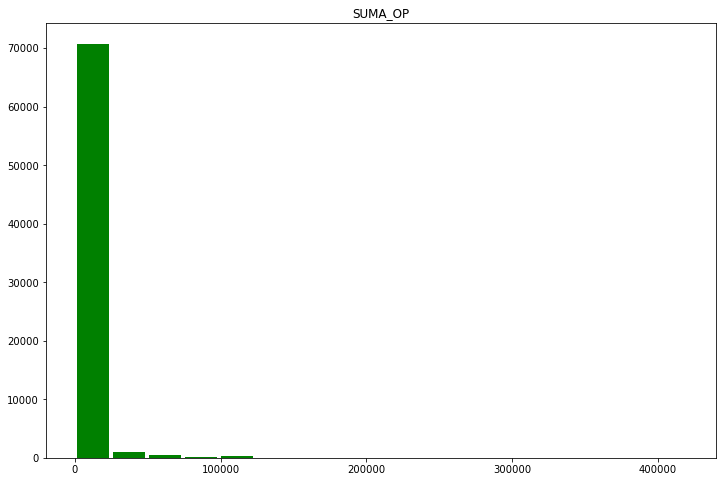

In [197]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

####GENERANDO EL PRIMIER LIMITE PARA EXCLUIR LOS OUTLINERS
datos = df202108['SUMA_OP'].astype(float)

k = int(1 + 3.322 * math.log10(len(datos)))

inf = datos.min()        # Limite inferior del primer intervalo
dif = datos.max()
sup = datos.max() + 1    # Limite superior del último intervalo

intervals = pd.interval_range(
    start=inf,
    end=sup,
    periods=k,
    name="Intervalo",
    closed="left")

lim_excluir = intervals[0].right ##SE BUSCA EL LIMITE SUPERIOR DEL PRIMER INTERVALO PARA ELIMINAR DE LA EVALUACIÓN

####OBTENIENDO DATAFRAME SIN DATOS OUTLIERS
df202108_lim_excluir = df202108[df202108['SUMA_OP'] >= lim_excluir]

###OBTENIENDO LOS K 
k = int(1 + 3.322 * math.log10(len(df202108_lim_excluir['SUMA_OP'].astype(float))))

###GENERANDO EL HISTOGRAMA
ax = df202108_lim_excluir.hist(column='SUMA_OP', bins=k, grid=False, figsize=(12,8), color='Green', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(True)
    x.spines['top'].set_visible(True)
    x.spines['left'].set_visible(True)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Montos", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Cantidad de Operaciones", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

## Imprimiendo Dataframe frecuencias
pd.set_option('precision', 2)
datos2 = df202108_lim_excluir['SUMA_OP'].astype(float)

    # Cálculo del número de intervalos
    # Si la parte entera de k es un número impar, redondeamos a la baja
k = 1 + 3.322 * math.log10(len(datos2))
numero = int(k)
if numero % 2 == 0:
    periodos = math.ceil(k)
else:
    periodos = int(k)

inf = datos2.min()        # Limite inferior del primer intervalo
dif = datos2.max()
sup = datos2.max() + 1    # Limite superior del último intervalo

intervals = pd.interval_range(
    start=inf,
    end=sup,
    periods=k,
    name="Intervalo",
    closed="left")

df202108_lim_excluir_frec = pd.DataFrame(index=intervals)
df202108_lim_excluir_frec["FreqAbs"] = pd.cut(datos2, bins=df202108_lim_excluir_frec.index).value_counts()
df202108_lim_excluir_frec["Marca"]  = df202108_lim_excluir_frec.index.mid

display(df202108_lim_excluir_frec)

***HISTOGRAMA Y DATAFRAME AUTOMATIZADO POR MES TRANSFERENCIAS OPERACIONES UNICAS***

In [ ]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

###CREANDO LISTA Y ORDENANDO POR MES DE MENOS A MAYOR
dataframes_valores_prueba = df_trans_ent_grupo_sum_unico.ANIOMES.unique()
dataframes_valores_prueba.sort()
dataframes_valores_prueba

####GENERANDO EL PRIMIER LIMITE PARA EXCLUIR LOS OUTLINERS

for i in dataframes_valores_prueba:
    #print(locals()[f'df{i}']['SUMA_OP'])
    #print ([f'df{i}'])
    
    datos = locals()[f'df{i}']['SUMA_OP'].astype(float)


    datos = locals()[f'df{i}']['SUMA_OP'].astype(float)

    k = int(1 + 3.322 * math.log10(len(datos)))

    inf = datos.min()        # Limite inferior del primer intervalo
    dif = datos.max()
    sup = datos.max() + 1    # Limite superior del último intervalo

    intervals = pd.interval_range(
        start=inf,
        end=sup,
        periods=k,
        name="Intervalo",
        closed="left")

    lim_excluir = intervals[0].right ##SE BUSCA EL LIMITE SUPERIOR DEL PRIMER INTERVALO PARA ELIMINAR DE LA EVALUACIÓN

    ####OBTENIENDO DATAFRAME SIN DATOS OUTLIERS
    locals()[f'df_{i}_excluir'] = locals()[f'df{i}'][locals()[f'df{i}']['SUMA_OP'] >= lim_excluir]

    ###OBTENIENDO LOS K 
    k = int(1 + 3.322 * math.log10(len(locals()[f'df_{i}_excluir']['SUMA_OP'].astype(float))))

############################
    ###GENERANDO EL HISTOGRAMA
    ax = locals()[f'df_{i}_excluir'].hist(column='SUMA_OP', bins=k, grid=False, figsize=(12,8), color='Green', zorder=2, rwidth=0.9)

    ax = ax[0]
    for x in ax:

        # Despine
        x.spines['right'].set_visible(True)
        x.spines['top'].set_visible(True)
        x.spines['left'].set_visible(True)

        # Switch off ticks
        x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

        # Draw horizontal axis lines
        vals = x.get_yticks()
        for tick in vals:
            x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

        # Remove title
        x.set_title("Mes " + i, weight='bold')

        # Set x-axis label
        x.set_xlabel("Montos", labelpad=20, weight='bold', size=12)

        # Set y-axis label
        x.set_ylabel("Cantidad de Operaciones", labelpad=20, weight='bold', size=12)

        # Format y-axis label
        x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))


    ## Imprimiendo Dataframe frecuencias
    pd.set_option('precision', 2)
    datos2 = locals()[f'df_{i}_excluir']['SUMA_OP'].astype(float)

        # Cálculo del número de intervalos
        # Si la parte entera de k es un número impar, redondeamos a la baja
    k = 1 + 3.322 * math.log10(len(datos2))
    numero = int(k)
    if numero % 2 == 0:
        periodos = math.ceil(k)
    else:
        periodos = int(k)

    inf = datos2.min()        # Limite inferior del primer intervalo
    dif = datos2.max()
    sup = datos2.max() + 1    # Limite superior del último intervalo

    intervals = pd.interval_range(
        start=inf,
        end=sup,
        periods=k,
        name="Intervalo",
        closed="left")

    locals()[f'df_{i}_frec_excluir'] = pd.DataFrame(index=intervals)
    locals()[f'df_{i}_frec_excluir']["FreqAbs"] = pd.cut(datos2, bins=locals()[f'df_{i}_frec_excluir'].index).value_counts()
    locals()[f'df_{i}_frec_excluir']["Marca"]  = locals()[f'df_{i}_frec_excluir'].index.mid
    print (i)
    display(locals()[f'df_{i}_frec_excluir'])

***HISTOGRAMA Y DATAFRAME AUTOMATIZADO POR MES TRANSFERENCIAS OPERACIONES MULTIPLES***

In [ ]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
pd.options.display.float_format = '{:.2f}'.format

###CREANDO LISTA Y ORDENANDO POR MES DE MENOS A MAYOR
dataframes_valores_prueba = df_trans_ent_grupo_sum_mul.ANIOMES.unique()
dataframes_valores_prueba.sort()
dataframes_valores_prueba

####GENERANDO EL PRIMIER LIMITE PARA EXCLUIR LOS OUTLINERS

for i in dataframes_valores_prueba:
    #print(locals()[f'df{i}']['SUMA_OP'])
    #print ([f'df{i}'])
    
    datos = locals()[f'df_mult{i}']['SUMA_OP'].astype(float)


    datos = locals()[f'df_mult{i}']['SUMA_OP'].astype(float)

    k = int(1 + 3.322 * math.log10(len(datos)))

    inf = datos.min()        # Limite inferior del primer intervalo
    dif = datos.max()
    sup = datos.max() + 1    # Limite superior del último intervalo

    intervals = pd.interval_range(
        start=inf,
        end=sup,
        periods=k,
        name="Intervalo",
        closed="left")

    lim_excluir = intervals[0].right ##SE BUSCA EL LIMITE SUPERIOR DEL PRIMER INTERVALO PARA ELIMINAR DE LA EVALUACIÓN

    ####OBTENIENDO DATAFRAME SIN DATOS OUTLIERS
    locals()[f'df_mul_{i}_excluir'] = locals()[f'df_mult{i}'][locals()[f'df_mult{i}']['SUMA_OP'] >= lim_excluir]

    ###OBTENIENDO LOS K 
    k = int(1 + 3.322 * math.log10(len(locals()[f'df_mul_{i}_excluir']['SUMA_OP'].astype(float))))

############################
    ###GENERANDO EL HISTOGRAMA
    ax = locals()[f'df_mul_{i}_excluir'].hist(column='SUMA_OP', bins=k, grid=False, figsize=(12,8), color='Green', zorder=2, rwidth=0.9)

    ax = ax[0]
    for x in ax:

        # Despine
        x.spines['right'].set_visible(True)
        x.spines['top'].set_visible(True)
        x.spines['left'].set_visible(True)

        # Switch off ticks
        x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

        # Draw horizontal axis lines
        vals = x.get_yticks()
        for tick in vals:
            x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

        # Remove title
        x.set_title("Mes " + i, weight='bold')

        # Set x-axis label
        x.set_xlabel("Montos", labelpad=20, weight='bold', size=12)

        # Set y-axis label
        x.set_ylabel("Cantidad de Operaciones", labelpad=20, weight='bold', size=12)

        # Format y-axis label
        x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))


    ## Imprimiendo Dataframe frecuencias
    pd.set_option('precision', 2)
    datos2 = locals()[f'df_mul_{i}_excluir']['SUMA_OP'].astype(float)

        # Cálculo del número de intervalos
        # Si la parte entera de k es un número impar, redondeamos a la baja
    k = 1 + 3.322 * math.log10(len(datos2))
    numero = int(k)
    if numero % 2 == 0:
        periodos = math.ceil(k)
    else:
        periodos = int(k)

    inf = datos2.min()        # Limite inferior del primer intervalo
    dif = datos2.max()
    sup = datos2.max() + 1    # Limite superior del último intervalo

    intervals = pd.interval_range(
        start=inf,
        end=sup,
        periods=k,
        name="Intervalo",
        closed="left")

    locals()[f'df_mul_{i}_frec_excluir'] = pd.DataFrame(index=intervals)
    locals()[f'df_mul_{i}_frec_excluir']["FreqAbs"] = pd.cut(datos2, bins=locals()[f'df_mul_{i}_frec_excluir'].index).value_counts()
    locals()[f'df_mul_{i}_frec_excluir']["Marca"]  = locals()[f'df_mul_{i}_frec_excluir'].index.mid
    print (i)
    display(locals()[f'df_mul_{i}_frec_excluir'])

In [191]:
df_trans_sal

,Transferencia,Fecha Presentación,Fecha Liquidación,Sesión,Moneda,IMPORTE,Comisión Interbancaria,Comisión Cliente,Comisión Rechazo Cliente,Itf Transferencia,...,DNI_BENEFICIARIO,Cuenta Destino,Caja,Secuencia Transf. Multiples,CCI_Destino_2,ANIO,MES,ANIOMES,Importe Transferencia,IMPORTE_FINAL
68114,S - SALID,2021-08-31,2021-08-31,3 - Tercera Sesión,1 - Soles,200.00,0.00,0.00,0,0.00,...,NaN,NaN,NaN,NaN,00219310351929704317,2021,08,202108,None,200.00
68115,S - SALID,2021-08-31,2021-08-31,3 - Tercera Sesión,1 - Soles,20.00,0.00,0.00,0,0.00,...,NaN,NaN,NaN,NaN,00230513446860105515,2021,08,202108,None,20.00
68116,S - SALID,2021-08-31,2021-08-31,3 - Tercera Sesión,1 - Soles,300.00,0.00,0.00,0,0.00,...,NaN,NaN,NaN,NaN,00219119761465005451,2021,08,202108,None,300.00
68117,S - SALID,2021-08-31,2021-08-31,3 - Tercera Sesión,1 - Soles,600.00,7.00,0.00,0,0.00,...,NaN,NaN,NaN,NaN,00320001311360742033,2021,08,202108,None,600.00
68118,S - SALID,2021-08-31,2021-08-31,3 - Tercera Sesión,1 - Soles,600.00,0.80,0.00,0,0.00,...,NaN,NaN,NaN,NaN,00902120032024692974,2021,08,202108,None,600.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78704,S - SALID,2021-09-01,2021-09-01,3 - Tercera Sesión,1 - Soles,369.32,0.80,0.00,0,0.00,...,NaN,NaN,NaN,NaN,01181400020275234414,2021,09,202109,None,369.32
78705,S - SALID,2021-09-01,2021-09-01,3 - Tercera Sesión,1 - Soles,300.00,0.00,0.00,0,0.00,...,NaN,NaN,NaN,NaN,01123400020020895424,2021,09,202109,None,300.00
78706,S - SALID,2021-09-01,2021-09-01,1 - Turno Mañana,1 - Soles,500.00,7.00,0.00,0,0.00,...,NaN,NaN,NaN,NaN,01863400463403640268,2021,09,202109,None,500.00
78707,S - SALID,2021-09-01,2021-09-01,3 - Tercera Sesión,1 - Soles,20.00,0.00,0.00,0,0.00,...,NaN,NaN,NaN,NaN,00219119366332501754,2021,09,202109,None,20.00
